<a href="https://colab.research.google.com/github/daksha200/Projects/blob/testrepo/German_Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

German Traffic Sign classification

In [15]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time

In [16]:
# Device configuration (whether to run on GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [17]:
# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [18]:
!gdown --id 1V7dt70fz_AKRJlttyjnrtFpuJDLXr15x

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1V7dt70fz_AKRJlttyjnrtFpuJDLXr15x
From (redirected): https://drive.google.com/uc?id=1V7dt70fz_AKRJlttyjnrtFpuJDLXr15x&confirm=t&uuid=46c40792-fbaf-441e-abd9-221deeef6aa8
To: /content/german_traffic_signs_dataset.zip
100% 68.2M/68.2M [00:00<00:00, 111MB/s]


In [14]:
# Unzip
!unzip -q german_traffic_signs_dataset.zip

replace german_traffic_signs_dataset/Test/0/00243.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(0, translate=(0.3,0.3), shear=5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = ImageFolder('german_traffic_signs_dataset/Train', transform=transform)
testset = ImageFolder('german_traffic_signs_dataset/Test', transform=transform)

Train, validation and test dataloaders

In [24]:
# Shuffle and split train set into 80% training and 20% validation set
val_split = 0.2
indices = np.arange(len(trainset))
np.random.shuffle(indices)
partition = int((1-val_split)*len(trainset))

#SubsetRandomSampler will only sample examples from the given subset of data
train_loader = DataLoader(trainset, shuffle=False, sampler=SubsetRandomSampler(indices[:partition]), batch_size=64, num_workers=2)
val_loader = DataLoader(trainset, shuffle=False, sampler=SubsetRandomSampler(indices[partition:]), batch_size=64, num_workers=2)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': partition, 'val': len(train_loader.dataset) - partition}

test_loader = DataLoader(testset, shuffle=False, batch_size=64, num_workers=2)

In [25]:
# Print dataset information
print('Number of training images: ', dataset_sizes['train'])
print('Number of validation images: ', dataset_sizes['val'])
print('Number of test images: ', len(test_loader.dataset))
print('Number of classes: ', len(trainset.classes))

Number of training images:  6880
Number of validation images:  1720
Number of test images:  2000
Number of classes:  43


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


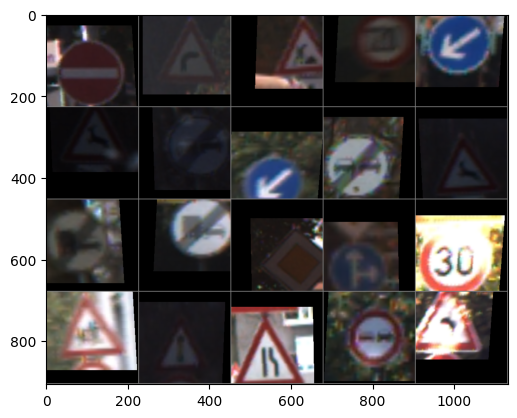

In [33]:
# Helper function to show an image
def plot_image(img):
    img = img / 2 + 0.5                         # unnormalize the image
    npimg = img.numpy()                         # torch to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # as torch image is (C, H, W)
    plt.show()

# Get some random training images from dataloader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot images
plot_image(torchvision.utils.make_grid(images[:20], nrow=5))

Helper functions for training/testing

In [34]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    since = time.time()

    # best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Enable grads if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Running loss and correct predictions
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Save loss and acc values
            if phase == 'train':
              train_losses.append(epoch_loss)
              train_acc.append(epoch_acc)
            else:
              val_losses.append(epoch_loss)
              val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc*100))

            # Save the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc*100))

    return train_losses, val_losses, train_acc, val_acc

In [35]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0
    correct = 0
    for i, (images, labels) in enumerate(test_loader):
      with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, preds = torch.max(output, dim=1)
        correct += (preds == labels).sum()

    test_acc = correct / len(test_loader.dataset)
    print('Test Accuracy: {:.4f}'.format(test_acc*100))

1. Finetuning

Here, we will load a pretrained model ResNet18 available in Pytorch and reset final fully connected layer. The model is trained on ImageNet dataset which is a large dataset containing 1000 classes.

In [36]:
# Load pretrained model
model = torchvision.models.resnet18(pretrained=True)

# Reset classifier to 43 output units (number of classes in our dataset)
model.fc = nn.Linear(model.fc.in_features, 43)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Define loss function

In [37]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

Define optimizer

In [38]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Training:

In [39]:
# Accuracy on test data before training
test_model(model, test_loader)

Test Accuracy: 2.0500


In [ ]:
history = train_model(model, criterion, optimizer, dataloaders, num_epochs=6)

Epoch 0/5
----------


Plot training plots

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(history[0])+1),history[0])
ax.plot(np.arange(1,len(history[1])+1),history[1])
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend(['Train Loss', 'Val Loss'])

Evaluate model

In [ ]:
# Accuracy on test data after training
test_model(model, test_loader)

2. Feature Extraction

Here, in the second approach, we will create a new instance of network and freeze entire network parameters except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()



In [ ]:
# Load pretrained model
model_conv = torchvision.models.resnet18(pretrained=True)

# Freeze all parameters
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of new classifier have requires_grad=True by default
# so grads will be computed for classifier only
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 43)

model_conv = model_conv.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Evaluate model on test data before training
print('Before training')
test_model(model_conv, test_loader)

Training

In [ ]:
history = train_model(model_conv, criterion, optimizer_conv, dataloaders, num_epochs=5)

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(history[0])+1),history[0])
ax.plot(np.arange(1,len(history[1])+1),history[1])
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend(['Train Loss', 'Val Loss'])

Evaluate model


In [ ]:
# Accuracy on test data after training
test_model(model_conv, test_loader)

As you can see, the test accuracy for feature extraction approach is not good compared to the first approach, although we are using pretrained models in both cases. Also, note that the training time was reduced to about half this time. This is obvious as we are not computing all the gradients this time.